Download and Setup

In [ ]:
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import os
import pandas as pd
import numpy as np

means = [0.485, 0.456, 0.406]
stds  = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    lambda x: x.convert('RGB'),
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import pandas as pd

class DDI_Dataset(Dataset):
    def __init__(self, root, csv_path=None, transform=None):
        self.root = root
        if csv_path is None:
            csv_path = os.path.join(os.path.dirname(root), "ddi_metadata.csv")

        # Load the annotations from the CSV file
        self.annotations = pd.read_csv(csv_path)
        self.image_files = self.annotations['DDI_file'].tolist()
        self.transform = transform

        # Add a 'malignant' column if it's not already present
        m_key = 'malignant'
        if m_key not in self.annotations:
            self.annotations[m_key] = self.annotations['malignancy(malig=1)'].apply(lambda x: x == 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Get the image file name and full path
        file_name = self.image_files[index]
        img_path = os.path.join(self.root, file_name)

        # Load the image
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        # Get the annotation for this image
        annotation = self.annotations.iloc[index]
        target = int(annotation['malignant'])  # 1 if malignant, 0 if benign
        skin_tone = annotation['skin_tone']    # Fitzpatrick- 12, 34, or 56

        return img_path, img, target, skin_tone

    def subset(self, skin_tone=None, diagnosis=None):
        skin_tone = [12, 34, 56] if skin_tone is None else skin_tone
        diagnosis = ["benign", "malignant"] if diagnosis is None else diagnosis

        # Validate the provided skin tones and diagnoses
        for si in skin_tone:
            assert si in [12, 34, 56], f"{si} is not a valid skin tone"
        for di in diagnosis:
            assert di in ["benign", "malignant"], f"{di} is not a valid diagnosis"

        # Filter the annotations based on skin tone and diagnosis
        filtered_annotations = self.annotations[
            (self.annotations['skin_tone'].isin(skin_tone)) &
            (self.annotations['malignant'].isin([di == "malignant" for di in diagnosis]))
        ]

        # Get the indices of the filtered annotations
        indices = filtered_annotations.index.tolist()

        # Return a subset of the dataset based on the filtered indices
        return Subset(self, indices)


Image 1:
Path: /content/DDI/images/000001.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


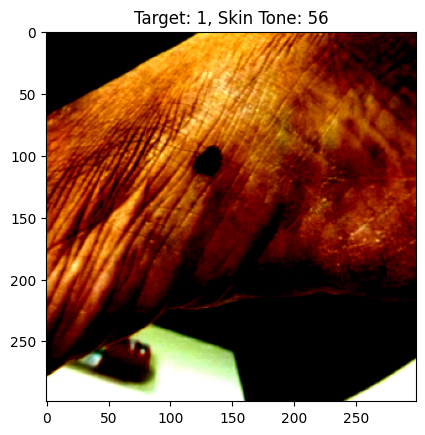

Image 2:
Path: /content/DDI/images/000002.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


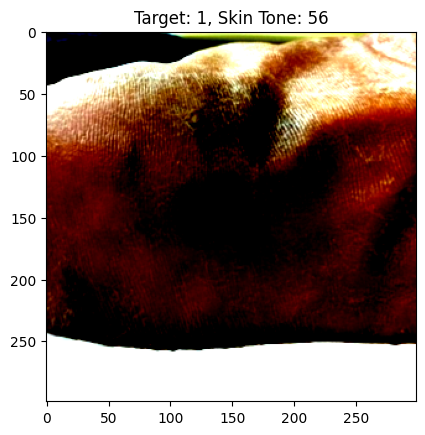

Image 3:
Path: /content/DDI/images/000003.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


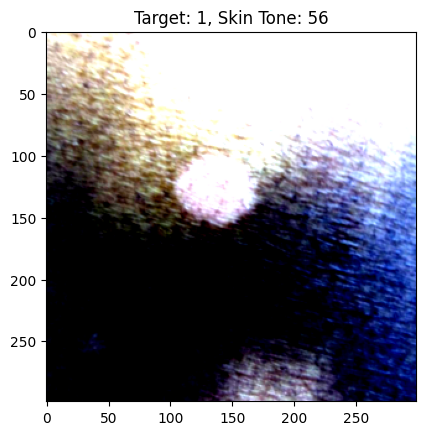

Image 4:
Path: /content/DDI/images/000004.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 56


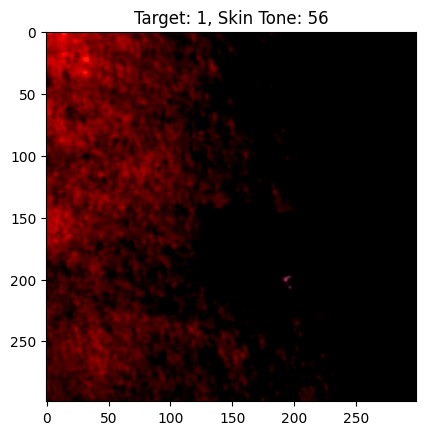

Image 5:
Path: /content/DDI/images/000005.png
Target (Malignant: 1, Benign: 0): 1
Skin Tone: 12


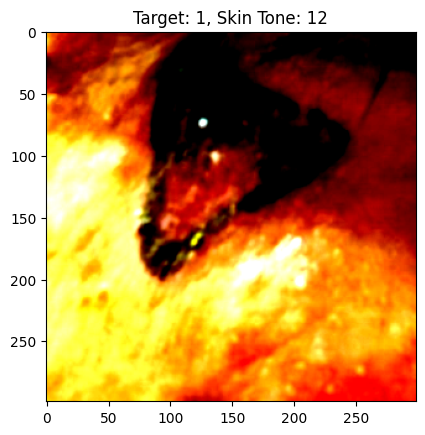

In [ ]:
import matplotlib.pyplot as plt

root = '/content/DDI/images'
dataset = DDI_Dataset(root=root, transform=test_transform)

for i in range(5):
    path, img, target, skin_tone = dataset[i]
    print(f"Image {i+1}:")
    print(f"Path: {path}")
    print(f"Target (Malignant: 1, Benign: 0): {target}")
    print(f"Skin Tone: {skin_tone}")

    plt.imshow(img.permute(1, 2, 0))  # Permute the tensor dimensions to (H, W, C) for plotting
    plt.title(f"Target: {target}, Skin Tone: {skin_tone}")
    plt.show()

In [ ]:
import os
import pandas as pd

df = pd.read_csv('/content/DDI/ddi_metadata.csv')

df['disease_label'] = df['disease'].astype('category').cat.codes

df.to_csv('/content/DDI/labeled_ddi_metadata.csv', index=False)

print(df[['DDI_ID', 'disease', 'disease_label']].head())

unique_labels = df[['disease', 'disease_label']].drop_duplicates().sort_values('disease_label')
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_colwidth', None)
print(unique_labels)

   DDI_ID                          disease  disease_label
0       1                 melanoma-in-situ             47
1       2                 melanoma-in-situ             47
2       3                mycosis-fungoides             51
3       4  squamous-cell-carcinoma-in-situ             67
4       5             basal-cell-carcinoma             11
                                          disease  disease_label
66    abrasions-ulcerations-and-physical-injuries              0
603                                       abscess              1
211                                   acne-cystic              2
76                 acquired-digital-fibrokeratoma              3
653                        acral-melanotic-macule              4
59                                    acrochordon              5
263                             actinic-keratosis              6
134                                angioleiomyoma              7
163                                       angioma              8
20

Model

In [ ]:
pip install scikit-learn

In [ ]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Define normalization parameters
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]
test_transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=means, std=stds)
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.image_paths = self.data['DDI_file'].values
        self.labels = self.data['disease_label'].values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, str(self.image_paths[idx]))
        img = Image.open(img_path).convert('RGB')
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, label


# Load dataset and create dataloader
root = '/content/DDI/images'
csv_file = '/content/DDI/labeled_ddi_metadata.csv'
dataset = CustomDataset(csv_file=csv_file, root_dir=root, transform=test_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SqueezeExcitation, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Squeeze: Global Average Pooling
        batch_size, num_channels, _, _ = x.size()
        squeeze = nn.functional.adaptive_avg_pool2d(x, 1).view(batch_size, num_channels)

        # Excitation
        excitation = self.fc1(squeeze)
        excitation = nn.functional.relu(excitation)
        excitation = self.fc2(excitation)
        excitation = self.sigmoid(excitation).view(batch_size, num_channels, 1, 1)

        return x * excitation

# ViT Adapter for 78-class classification
class ViTAdapter(nn.Module):
    def __init__(self, num_classes=78, reduction=16):
        super(ViTAdapter, self).__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        self.se = SqueezeExcitation(channels=self.vit.heads.head.in_features, reduction=reduction)
        self.vit.heads = nn.Linear(self.vit.heads.head.in_features, num_classes)

    def forward(self, x):
        x = self.vit(x)
        return x

# Initialize model
model = ViTAdapter().to(device)
model.train()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
def train_model(dataloader, model, criterion, optimizer, epochs=27):
    for epoch in range(epochs):
        running_loss = 0.0
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

train_model(dataloader, model, criterion, optimizer)

# Feature extraction function
def extract_features(dataloader, model):
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feature = model.vit(imgs)
            features.append(feature.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features and split data
features, labels = extract_features(dataloader, model)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Scale features and train logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0)
clf.fit(X_train, y_train)

# Predict and evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1, Loss: 3.6112
Epoch 2, Loss: 3.1381
Epoch 3, Loss: 2.5240
Epoch 4, Loss: 1.6494
Epoch 5, Loss: 0.8065
Epoch 6, Loss: 0.3198
Epoch 7, Loss: 0.1159
Epoch 8, Loss: 0.0486
Epoch 9, Loss: 0.0348
Epoch 10, Loss: 0.0411
Epoch 11, Loss: 0.0214
Epoch 12, Loss: 0.0162
Epoch 13, Loss: 0.0131
Epoch 14, Loss: 0.0111
Epoch 15, Loss: 0.0098
Epoch 16, Loss: 0.0088
Epoch 17, Loss: 0.0079
Epoch 18, Loss: 0.0072
Epoch 19, Loss: 0.0067
Epoch 20, Loss: 0.0061
Epoch 21, Loss: 0.0057
Epoch 22, Loss: 0.0053
Epoch 23, Loss: 0.0050
Epoch 24, Loss: 0.0047
Epoch 25, Loss: 0.0044
Epoch 26, Loss: 0.0041
Epoch 27, Loss: 0.0039
Accuracy: 0.93182


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(1, 79))

# Initialize overall metrics
total_tp = total_fn = total_fp = total_tn = 0

# Calculate overall metrics
for i in range(cm.shape[0]):
    tp = cm[i, i]  # True positive
    fn = cm[i, :].sum() - tp  # False negative
    fp = cm[:, i].sum() - tp  # False positive
    tn = cm.sum() - (fp + fn + tp)  # True negative

    total_tp += tp
    total_fn += fn
    total_fp += fp
    total_tn += tn

# Calculate overall metrics
overall_sensitivity = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_specificity = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0
overall_false_positive_rate = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0
overall_false_negative_rate = total_fn / (total_fn + total_tp) if (total_fn + total_tp) > 0 else 0

# Print overall metrics
print(f"Overall Sensitivity: {overall_sensitivity:.4f}")
print(f"Overall Specificity: {overall_specificity:.4f}")
print(f"Overall False Positive Rate: {overall_false_positive_rate:.4f}")
print(f"Overall False Negative Rate: {overall_false_negative_rate:.4f}")


Overall Sensitivity: 0.9318
Overall Specificity: 0.9991
Overall False Positive Rate: 0.0009
Overall False Negative Rate: 0.0682


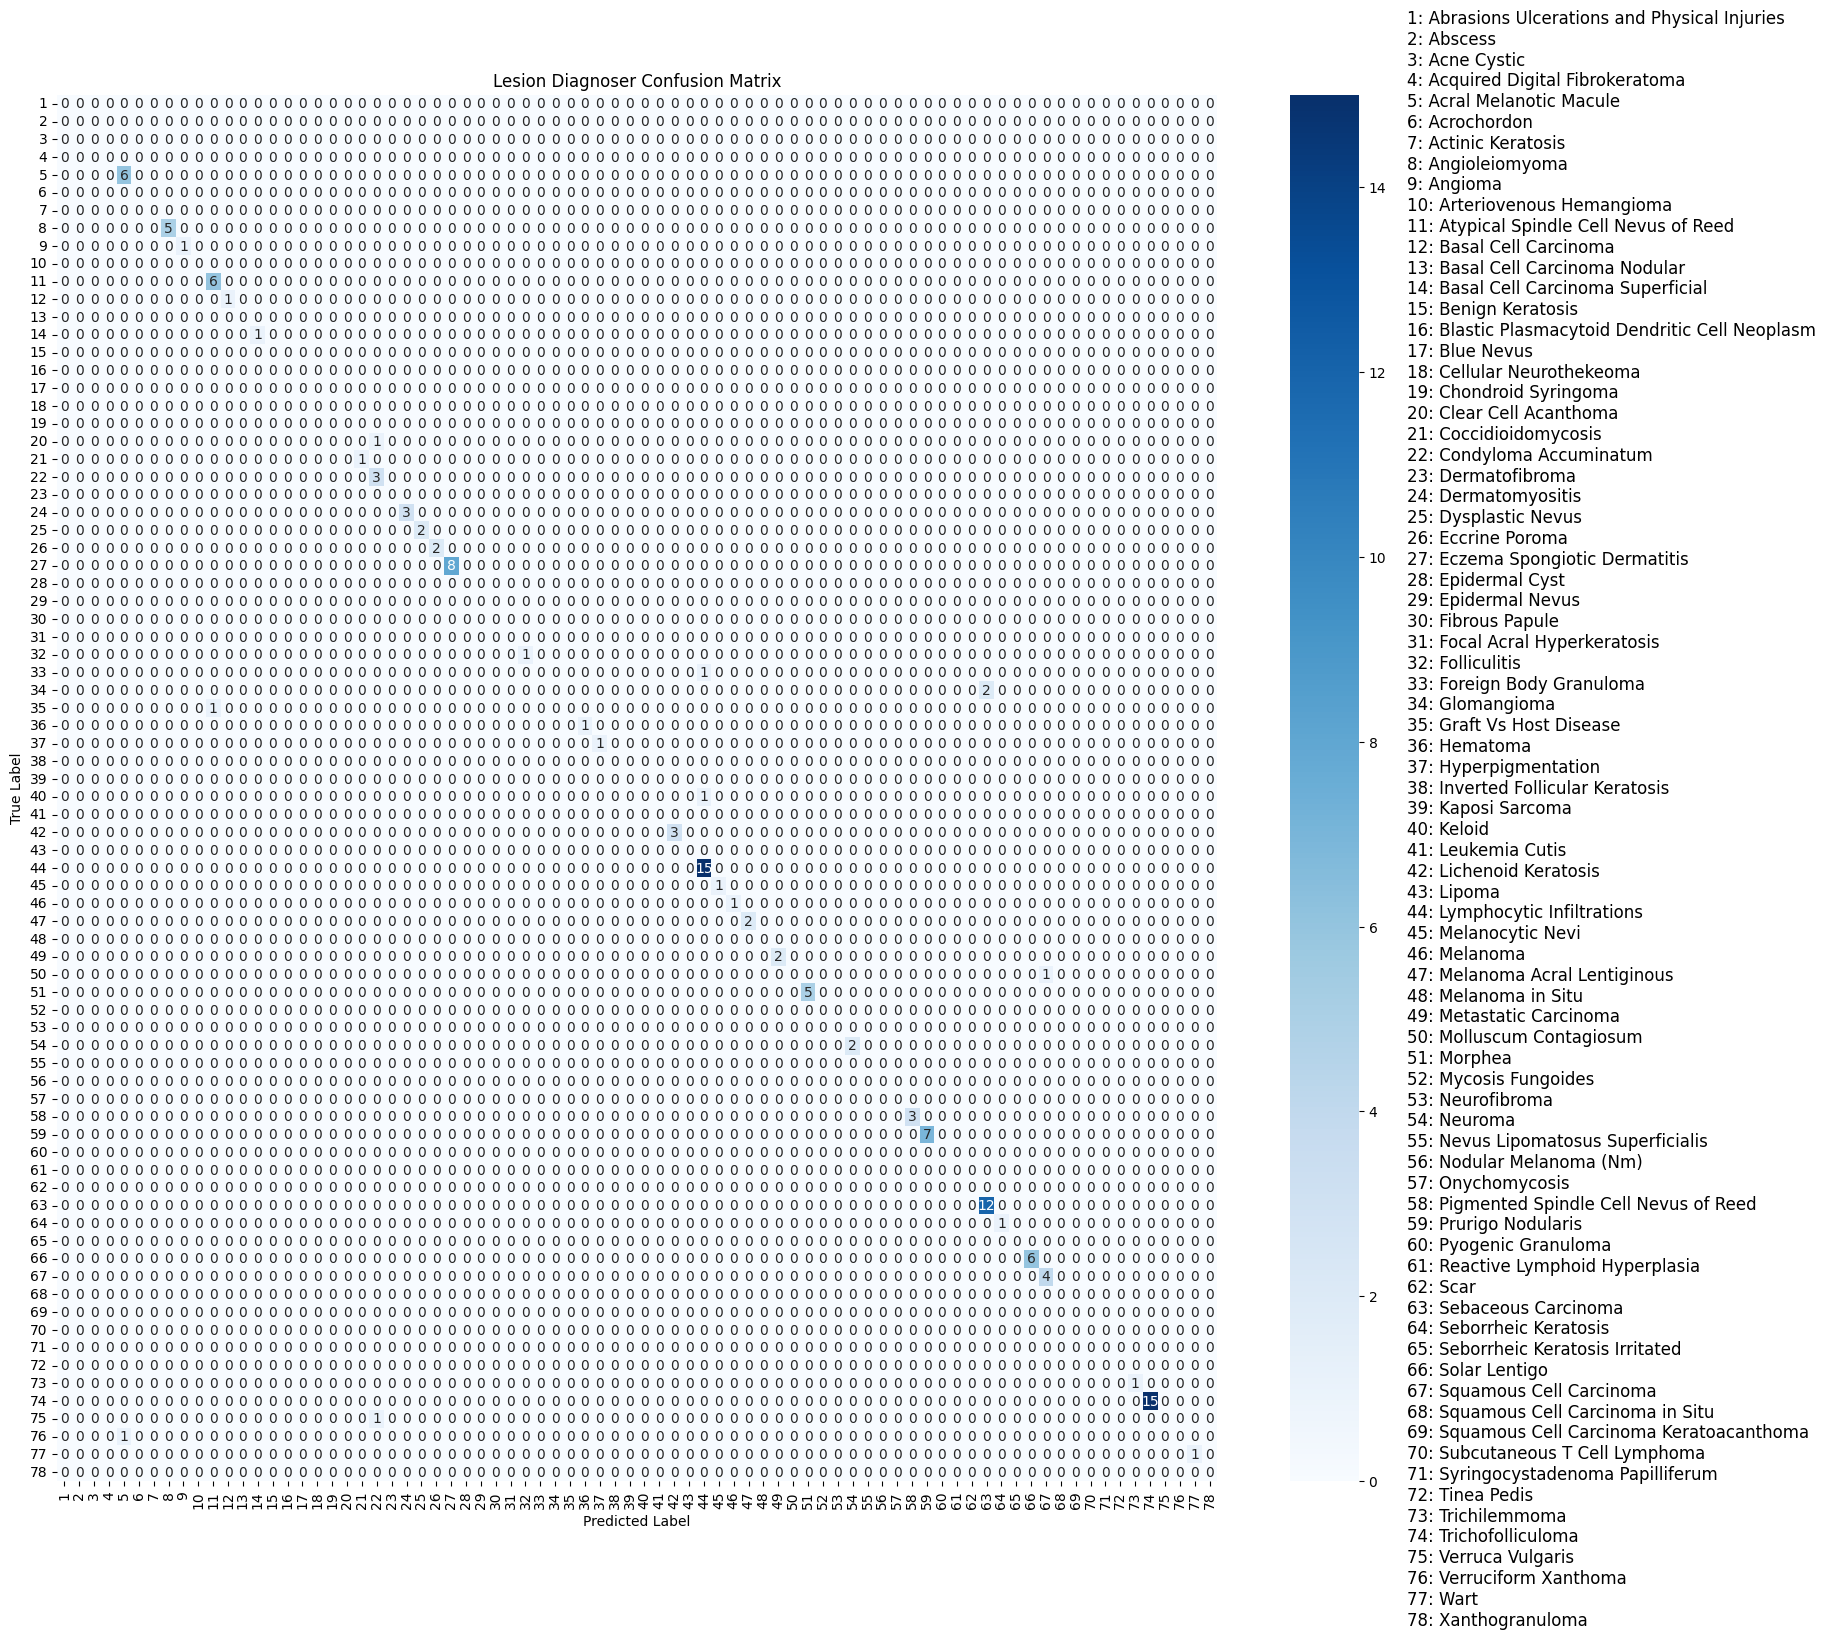

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np  # Ensure you import numpy for np.pad()

# Define disease labels
labels = [
    'Abrasions Ulcerations and Physical Injuries', 'Abscess', 'Acne Cystic',
    'Acquired Digital Fibrokeratoma', 'Acral Melanotic Macule', 'Acrochordon',
    'Actinic Keratosis', 'Angioleiomyoma', 'Angioma', 'Arteriovenous Hemangioma',
    'Atypical Spindle Cell Nevus of Reed', 'Basal Cell Carcinoma', 'Basal Cell Carcinoma Nodular',
    'Basal Cell Carcinoma Superficial', 'Benign Keratosis', 'Blastic Plasmacytoid Dendritic Cell Neoplasm',
    'Blue Nevus', 'Cellular Neurothekeoma', 'Chondroid Syringoma', 'Clear Cell Acanthoma',
    'Coccidioidomycosis', 'Condyloma Accuminatum', 'Dermatofibroma', 'Dermatomyositis',
    'Dysplastic Nevus', 'Eccrine Poroma', 'Eczema Spongiotic Dermatitis', 'Epidermal Cyst',
    'Epidermal Nevus', 'Fibrous Papule', 'Focal Acral Hyperkeratosis', 'Folliculitis',
    'Foreign Body Granuloma', 'Glomangioma', 'Graft Vs Host Disease', 'Hematoma',
    'Hyperpigmentation', 'Inverted Follicular Keratosis', 'Kaposi Sarcoma', 'Keloid',
    'Leukemia Cutis', 'Lichenoid Keratosis', 'Lipoma', 'Lymphocytic Infiltrations',
    'Melanocytic Nevi', 'Melanoma', 'Melanoma Acral Lentiginous', 'Melanoma in Situ',
    'Metastatic Carcinoma', 'Molluscum Contagiosum', 'Morphea', 'Mycosis Fungoides',
    'Neurofibroma', 'Neuroma', 'Nevus Lipomatosus Superficialis', 'Nodular Melanoma (Nm)',
    'Onychomycosis', 'Pigmented Spindle Cell Nevus of Reed', 'Prurigo Nodularis',
    'Pyogenic Granuloma', 'Reactive Lymphoid Hyperplasia', 'Scar', 'Sebaceous Carcinoma',
    'Seborrheic Keratosis', 'Seborrheic Keratosis Irritated', 'Solar Lentigo',
    'Squamous Cell Carcinoma', 'Squamous Cell Carcinoma in Situ', 'Squamous Cell Carcinoma Keratoacanthoma',
    'Subcutaneous T Cell Lymphoma', 'Syringocystadenoma Papilliferum', 'Tinea Pedis',
    'Trichilemmoma', 'Trichofolliculoma', 'Verruca Vulgaris', 'Verruciform Xanthoma',
    'Wart', 'Xanthogranuloma'
]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(1, 79))

# Ensure cm has the correct shape (78, 78)
if cm.shape != (78, 78):
    cm = np.pad(cm, ((0, 78 - cm.shape[0]), (0, 78 - cm.shape[1])), mode='constant', constant_values=0)

# Generate numeric labels
numeric_labels = [str(i) for i in range(1, 79)]

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=numeric_labels, yticklabels=numeric_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Lesion Diagnoser Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Adjust the legend to show disease names
plt.subplots_adjust(right=0.85)
plt.figtext(0.8, 0.03, "\n".join(f"{i+1}: {label}" for i, label in enumerate(labels)), fontsize=12, ha='left')

plt.show()


In [ ]:
!pip install coremltools

In [ ]:
import coremltools as ct

In [ ]:
image_path = "/content/DDI/images/000001.png"
def load_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)
    return image

traceable_model = torch.jit.trace(model, load_image(image_path, test_transform).to(device))

# Define the input type for Core ML conversion
_input = ct.ImageType(
    name="input_1",
    shape=(1, 3, 299, 299),
    bias=[-m/s for m, s in zip(means, stds)],  # Bias correction (mean/std)
    scale=1.0/(255.0 * stds[0])  # Scale correction (1/(255 * std))
)

# Convert to Core ML
mlmodel = ct.convert(
    traceable_model,
    inputs=[_input]
)

mlmodel.user_defined_metadata['description'] = "Skin lesion classification model (ResNet18)"
mlmodel.user_defined_metadata['version'] = "1.0"
mlmodel.short_description = "Classifies skin lesions as benign or malignant."

# Save the model
mlmodel.save("Diagnoser.mlpackage")

Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 294.47 passes/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Move the model to Google Drive
!mv Diagnoser.mlpackage/ /content/drive/My\ Drive/

Mounted at /content/drive
